In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from glob import glob
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_dir = '/content/drive/My Drive/dataset/buah/mangga/train/'
val_dir='/content/drive/My Drive/dataset/buah/mangga/val/'

In [6]:
folders = glob('/content/drive/My Drive/dataset/buah/mangga/train/*')
folders

['/content/drive/My Drive/dataset/buah/mangga/train/healthy_sehat',
 '/content/drive/My Drive/dataset/buah/mangga/train/dieback_penyakitmatipucuk',
 '/content/drive/My Drive/dataset/buah/mangga/train/anthracnose_antraknosa',
 '/content/drive/My Drive/dataset/buah/mangga/train/bacterialcanker_kankerbakteri']

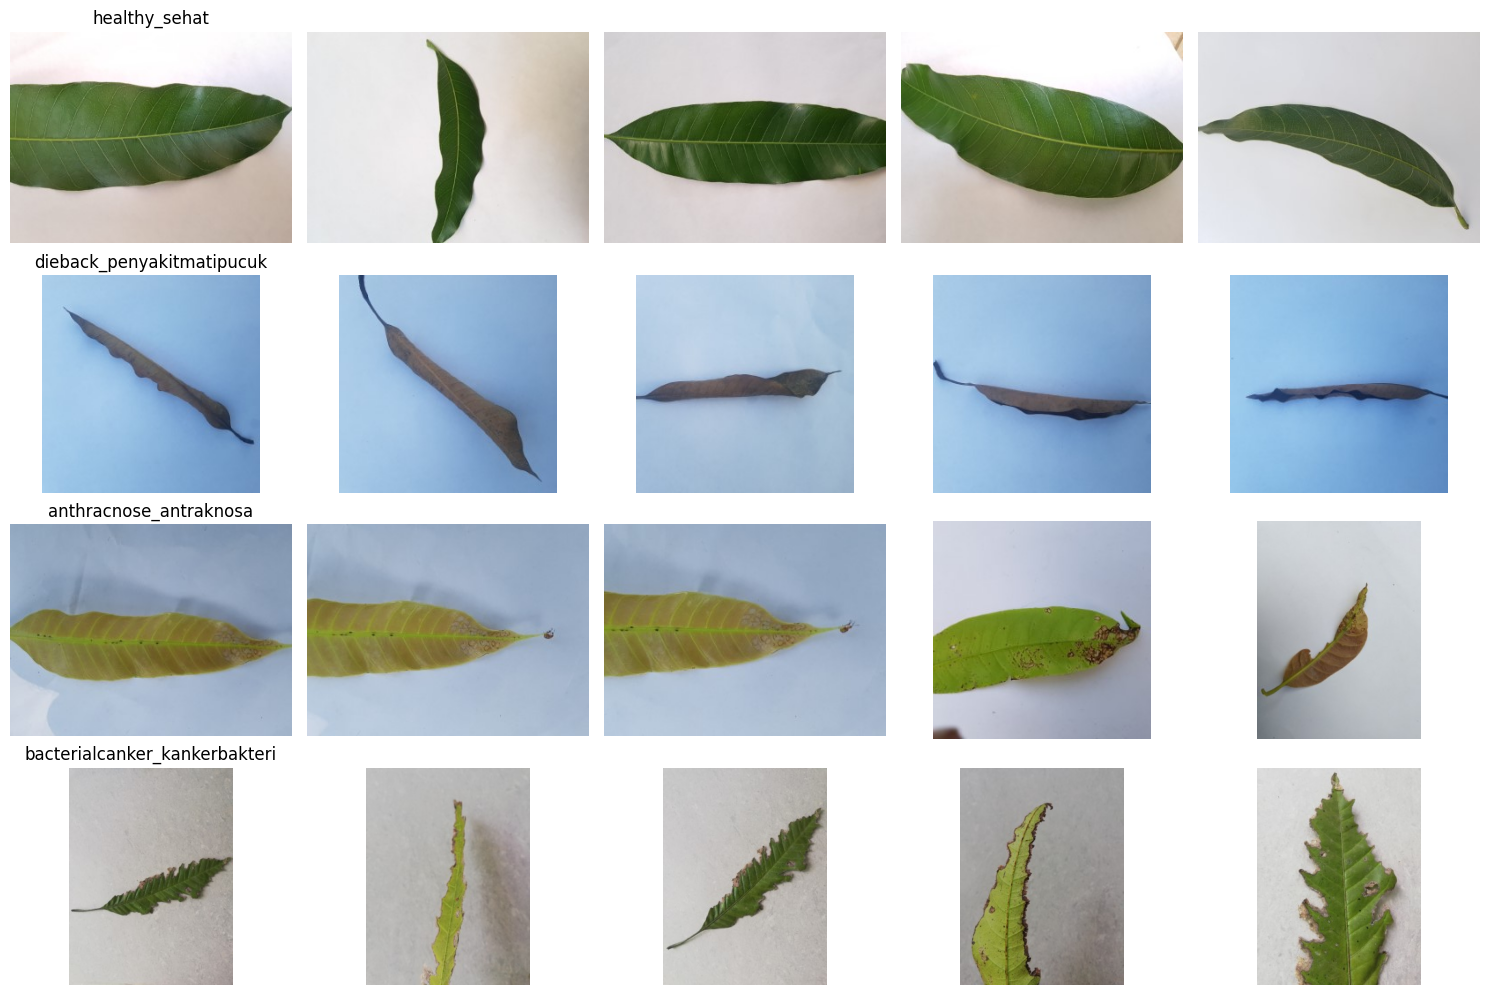

In [7]:
categories = os.listdir(train_dir)

plt.figure(figsize=(15, 10))
num_categories = len(categories)

for i, category in enumerate(categories):
    category_path = os.path.join(train_dir, category)
    image_files = os.listdir(category_path)[:5]

    for j, file in enumerate(image_files):
        img_path = os.path.join(category_path, file)
        img = load_img(img_path)
        plt.subplot(num_categories, 5, i * 5 + j + 1)
        plt.imshow(img)
        plt.axis('off')
        if j == 0:
            plt.title(category)

plt.tight_layout()
plt.show()

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Skalasi nilai pixel ke rentang [0, 1]
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

# Mendefinisikan generator untuk data train dan data validasi
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),  # Ukuran gambar yang diharapkan
        batch_size=32,
        class_mode='categorical')  # Mode kelas untuk klasifikasi multiclass

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

# Membangun arsitektur model CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(len(folders), activation='softmax')  # Jumlah kelas output
])

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [10]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# Melatih model
history=model.fit(
      train_generator,
      epochs=100,
      validation_data=validation_generator)

# Simpan model
model.save('mangga_disease_classifier.h5')

Epoch 1/100
50/50 [==============================] - 407s 8s/step - loss: 1.3663 - accuracy: 0.3681 - val_loss: 1.7290 - val_accuracy: 0.2525
Epoch 2/100
50/50 [==============================] - 16s 322ms/step - loss: 1.0273 - accuracy: 0.5594 - val_loss: 1.5331 - val_accuracy: 0.3825
Epoch 3/100
50/50 [==============================] - 17s 336ms/step - loss: 0.9148 - accuracy: 0.5875 - val_loss: 1.6354 - val_accuracy: 0.1850
Epoch 4/100
50/50 [==============================] - 17s 332ms/step - loss: 0.8273 - accuracy: 0.6331 - val_loss: 1.9516 - val_accuracy: 0.2925
Epoch 5/100
50/50 [==============================] - 16s 321ms/step - loss: 0.7629 - accuracy: 0.6506 - val_loss: 1.4387 - val_accuracy: 0.3375
Epoch 6/100
50/50 [==============================] - 16s 325ms/step - loss: 0.7006 - accuracy: 0.6894 - val_loss: 1.6578 - val_accuracy: 0.4425
Epoch 7/100
50/50 [==============================] - 16s 323ms/step - loss: 0.6445 - accuracy: 0.7100 - val_loss: 1.2085 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


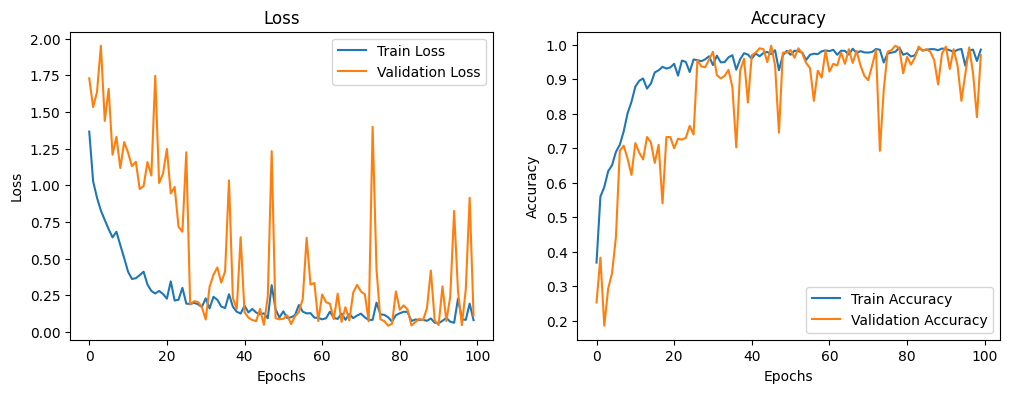

In [12]:
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()